# Self Normalising Neural Networks
In this notebook we will explore **Self-Normalising-Neural-Networks**

Links to papers:
* https://medium.com/@damoncivin/self-normalising-neural-networks-snn-2a972c1d421
* https://becominghuman.ai/paper-repro-self-normalizing-neural-networks-84d7df676902 
* https://arxiv.org/pdf/1706.02515.pdf

*The following are excerpts from the articles above:*

State of the art performance rarely comes from a 'vanilla' fully-connected neural network because training with SGD gets unstable after a few layers. 

Using Self-normalising-neural-networks (SNNs), the authors can train very deep vanilla nets to get state-of-the-art performance on 121 tasks in UCI repository.

## Normalization background
Normalization most often means transforming inputs to zero-mean and unit variance. This is often done as a pre-processing step. It speeds up learning and improves accuracy. Why? 

* Normalization makes the values of different features comparable 
* During training, the weights and parameters adjust those values
* This can mess up the scaling again, despite the pre-processing, which can cause the gradients to get out of control. This hurts learning. So normalisation needs to be applied during training. 

Many other normalization methods exists: Batch normalization, layer normalization, weight normalization, etc, but SGD and dropout perturb these kinds of normalizations, leading to high variance in training error. CNNs and RNNs get around this by sharing weights. The effect gets worse with depth, so deep vanilla networks tend to suck...

$$\text{SELU}(x) = \text{scale} * (\max(0,x) + \min(0, \alpha * (\exp(x) - 1)))
$$

## Key Results
Constructing neural networks this way ensures that the distribution of neuron activations remain stable. That is, the mean and variance of the data through each layer remains near 0 and 1 respectively. 

By simply using ```nn.SeLU()``` activation function, your neural network will train in such a way that the output of each layer will be roughly normally distributed with a mean of 0 and a variance of 1, as long as the input themselves are distributed in that way.

## AlphaDropout
We need a version of dropout which does two things:
* Sets dropped out units to $\alpha`$ instead of $0$
* It preserves both the zero mean and unit variance of the data. This means we need to transform the vector resulting from the first step somehow. 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [19]:
from torch import *

In [24]:
# Helper Functions and Classes 
# These will be funtions and classes we will use to construct our NNs and get data along with testing
def selu(x):
    alpha = torch.tensor(1.6732632423543772848170429916717)
    scale = torch.tensor(1.0507009873554804934193349852946)
    return scale * torch.where(x>=0.0, x, alpha * torch.exp(x) - alpha)

def stats(x): return x.mean(), x.std()

class Selu():
    def __init__(self):
        self.alpha = torch.tensor(1.6732632423543772848170429916717)
        self.scale = torch.tensor(1.0507009873554804934193349852946)
    def __call__(self, x):
        return self.scale * torch.where(x>=0.0, x, self.alpha * torch.exp(x) - self.alpha)
    
class Linear():
    def __init__(self, w, b): self.w, self.b = w,b
    def __call__(self, x): return x@self.w + self.b
    
class SeLU(nn.Module):
    # How pytorch implements this
    def __init__(self, lambd=1.0507, alpha=1.67326):
        super().__init__()
        self.lambd = lambd
        self.alpha = alpha
        
    def __call__(self, x):
        mask = (x > 0).type(x.data.type())
        return self.lambd * ((x * mask) + ((self.alpha * torch.exp(x) - self.alpha) * (1 - mask)))
    
    def forward(): self.__call__()
        
class AlphaDropout(nn.Module):
    # PyTorch implementation
    def __init__(self, dropout, lambd=1.0507, alpha=1.67326):
        super().__init__()
        self.lambd = lambd
        self.alpha = alpha
        self.aprime = -lambd * alpha
        
        self.q = 1 - dropout
        self.p = dropout
        
        self.a = (self.q + self.aprime**2 * self.q * self.p)**(-0.5)
        self.b = -self.a * (self.p * self.aprime)
        
    def __call__(self, x):
        if not self.training: return x # we don't want dropout at inference
        ones = torch.ones(x.size())
        mask = torch.bernoulli(ones * self.p)
        x = x.masked_fill(torch.autograd.Variable(mask.byte()), self.aprime)
        
        return x * self.a + self.a
        
    def forward(self): self.__call__()
        
def get_data_randn(num_in=512, method='kaiming'):
    x, b, w = torch.randn(num_in), torch.zeros(num_in), torch.randn(num_in, num_in)
    if method=='kaiming': w = w / math.sqrt(x.shape[0])
    elif method=='optimized': w = w * math.sqrt(2./x.shape[0]) # Xe Optimized
    elif method=='pytorch': w = w * math.sqrt(5./x.shape[0]) 
    else: print('Randomly initialized weights')
    return x, w, b

In [25]:
# Our Testing Models
# For now these models will be basic without any dropout. 
# One model will be a basic pytorch model
# The other will be our optimized model 
class Model_PyTorch(nn.Module):
    def __init__(self, num_in):
        super().__init__()
        self.layer = [nn.Linear(num_in, num_in), nn.SELU()]
        
    def __call__(self, x, num_layers, plot_stats=False):
        init_stats, in_x = stats(x), x
        with torch.no_grad():
            for i in range(num_layers):
                if not torch.isnan(x.mean()):
                    for l in self.layer: x = l(x)
        final_stats = stats(x)
        
        print(f'Iteration: {i+1}')
        print(f'Initial Activation Stats: {init_stats}')
        print(f'Final Activation Stats: {final_stats}')
        
        if plot_stats:
            f, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
            sns.distplot(in_x, ax=axes[0])
            sns.distplot(x, ax=axes[1])
            
        return i+1, init_stats, final_stats
    
class Model_Optimized():
    def __init__(self, data):
        self.x, self.w, self.b = data[0], data[1], data[2]
        self.linear, self.selu = Linear(self.w, self.b), Selu()
        self.layer = [self.linear, self.selu]
        
    def __call__(self, x, num_layers, plot_stats=False):
        init_stats, in_x = stats(x), x
        for i in range(num_layers):
            if not torch.isnan(x.mean()):
                for l in self.layer: x = l(x)
        final_stats = stats(x)
        
        print(f'Iteration: {i+1}')
        print(f'Initial Activation Stats: {init_stats}')
        print(f'Final Activation Stats: {final_stats}')
        
        if plot_stats:
            f, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
            sns.distplot(in_x, ax=axes[0])
            sns.distplot(x, ax=axes[1])
            
        return i+1, init_stats, final_stats

In [57]:
# Experimental Activations
class MinMax():
    def __call__(self, x): return (x - x.min) / (x.max - x.min)
    
class ReLU():
    def __call__(self, x): return x.clamp_min(.0)
    
class ReLU_Opt():
    def __call__(self, x): return x.clamp_min(.0) - 0.5
    
class MMR():
    """
    MinMax applied before ReLu
    """
    def __init__(self, relu_opt=False): 
        self.minmax = MinMax()
        self.relu = ReLU_Opt() if relu_opt else ReLU()
    def __call__(self, x, relu_type='pytorch'): return self.relu(self.minmax(x))

## Test 1. Activation Statistics
Let's first simulate an $N$ layered NN using PyTorch's implementation of SELU. We will test both with and without **AlphaDropout** which should make no difference if working correctly. 

Iteration: 1
Initial Activation Stats: (tensor(0.0376), tensor(1.0759))
Final Activation Stats: (tensor(-0.0447), tensor(0.7107))


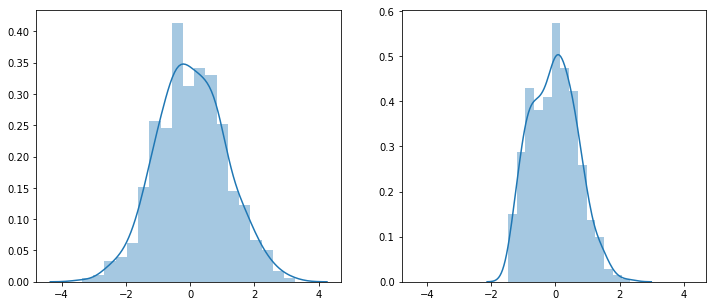

In [27]:
"""
TESTING: PyTorch Model
"""
num_layers = 1

########################################
num_in = 512
x,_,_ = get_data_randn()
model = Model_PyTorch(num_in)
_=model(x, num_layers, plot_stats=True)

Iteration: 5
Initial Activation Stats: (tensor(-0.0372), tensor(0.9758))
Final Activation Stats: (tensor(-0.0307), tensor(0.2020))


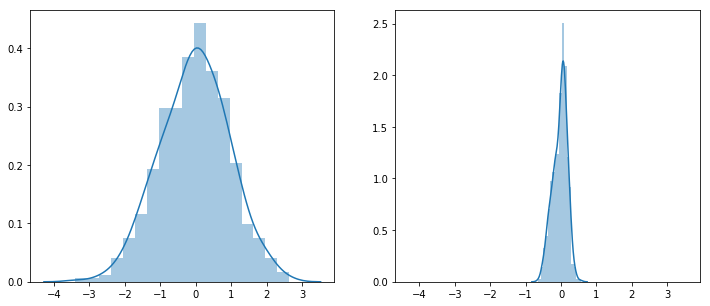

In [31]:
"""
TESTING: PyTorch Model
"""
num_layers = 5

########################################
num_in = 512
x,_,_ = get_data_randn()
model = Model_PyTorch(num_in)
_=model(x, num_layers, plot_stats=True)

Iteration: 10
Initial Activation Stats: (tensor(-0.0092), tensor(1.0305))
Final Activation Stats: (tensor(-0.0178), tensor(0.0871))


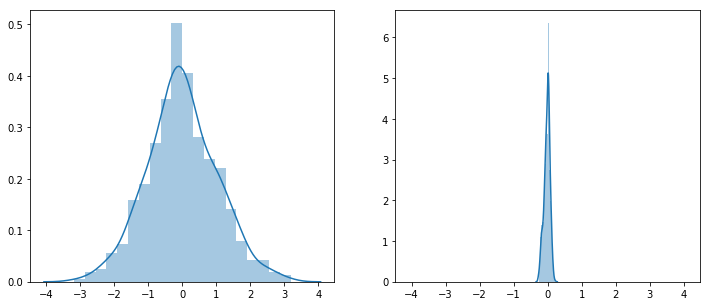

In [28]:
"""
TESTING: PyTorch Model
"""
num_layers = 10

########################################
num_in = 512
x,_,_ = get_data_randn()
model = Model_PyTorch(num_in)
_=model(x, num_layers, plot_stats=True)

Iteration: 1
Initial Activation Stats: (tensor(0.0777), tensor(1.0292))
Final Activation Stats: (tensor(0.0373), tensor(1.0496))


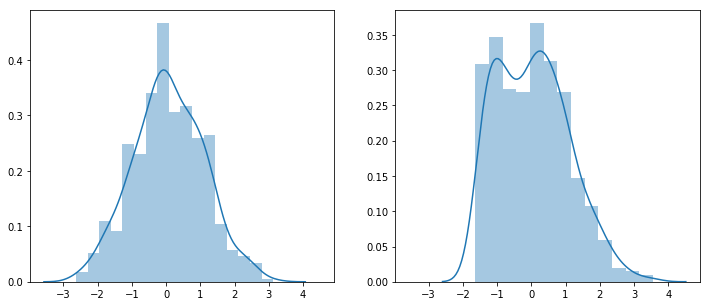

In [48]:
"""
TESTING: Optimized Model
"""
num_layers = 1

###########################################
num_in = 512
data = get_data_randn(method='kaiming')
x = data[0]
model = Model_Optimized(data)
_= model(x, num_layers, plot_stats=True)

Iteration: 10
Initial Activation Stats: (tensor(0.0630), tensor(1.0011))
Final Activation Stats: (tensor(-0.0267), tensor(0.9733))


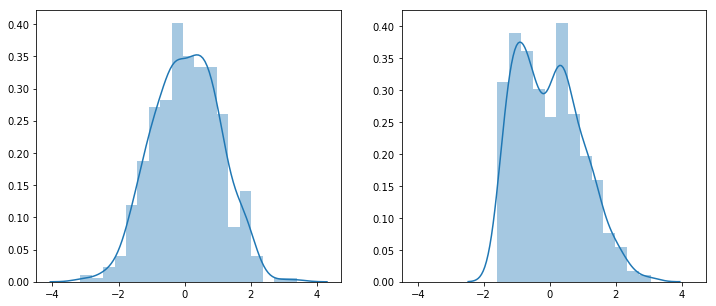

In [49]:
"""
TESTING: Optimized Model
"""
num_layers = 10

###########################################
num_in = 512
data = get_data_randn(method='kaiming')
x = data[0]
model = Model_Optimized(data)
_= model(x, num_layers, plot_stats=True)

Iteration: 100
Initial Activation Stats: (tensor(0.0288), tensor(0.9714))
Final Activation Stats: (tensor(0.0793), tensor(1.2172))


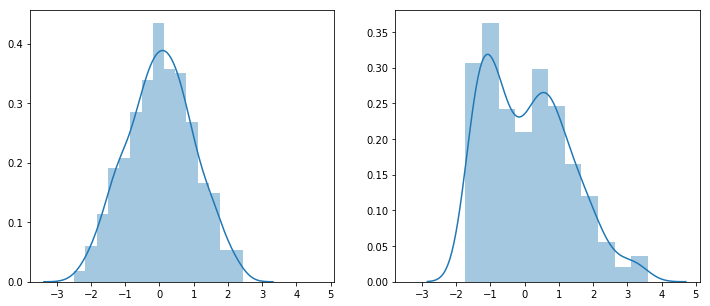

In [50]:
"""
TESTING: Optimized Model
"""
num_layers = 100

###########################################
num_in = 512
data = get_data_randn(method='kaiming')
x = data[0]
model = Model_Optimized(data)
_= model(x, num_layers, plot_stats=True)

Iteration: 1000
Initial Activation Stats: (tensor(0.0489), tensor(1.0178))
Final Activation Stats: (tensor(0.1136), tensor(1.1001))


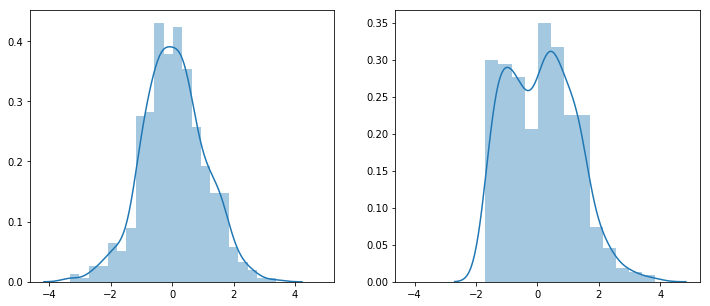

In [51]:
"""
TESTING: Optimized Model
"""
num_layers = 1000

###########################################
num_in = 512
data = get_data_randn(method='kaiming')
x = data[0]
model = Model_Optimized(data)
_= model(x, num_layers, plot_stats=True)

Iteration: 10000
Initial Activation Stats: (tensor(-0.0278), tensor(0.9718))
Final Activation Stats: (tensor(0.1947), tensor(1.3736))


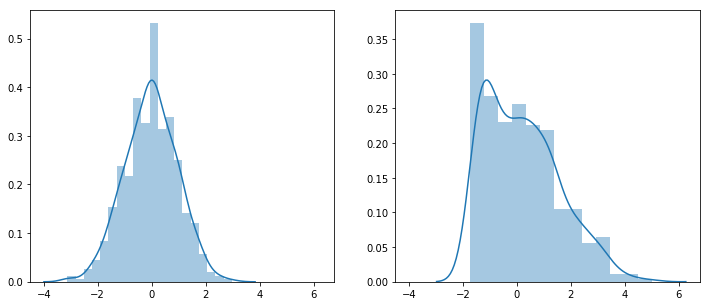

In [52]:
"""
TESTING: Optimized Model
"""
num_layers = 10000

###########################################
num_in = 512
data = get_data_randn(method='kaiming')
x = data[0]
model = Model_Optimized(data)
_= model(x, num_layers, plot_stats=True)

In [53]:
??nn.Linear

Init signature: nn.Linear(in_features, out_features, bias=True)
Source:        
class Linear(Module):
    r"""Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to ``False``, the layer will not learn an additive bias.
            Default: ``True``

    Shape:
        - Input: :math:`(N, *, H_{in})` where :math:`*` means any number of
          additional dimensions and :math:`H_{in} = \text{in\_features}`
        - Output: :math:`(N, *, H_{out})` where all but the last dimension
          are the same shape as the input and :math:`H_{out} = \text{out\_features}`.

    Attributes:
        weight: the learnable weights of the module of shape
            :math:`(\text{out\_features}, \text{in\_features})`. The values are
            initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`, where
            :math:`k = \frac{1}{\text{in\_f

In [54]:
nn.init.kaiming_uniform_??

Signature:
nn.init.kaiming_uniform_(
    tensor,
    a=0,
    mode='fan_in',
    nonlinearity='leaky_relu',
)
Source:   
def kaiming_uniform_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu'):
    r"""Fills the input `Tensor` with values according to the method
    described in `Delving deep into rectifiers: Surpassing human-level
    performance on ImageNet classification` - He, K. et al. (2015), using a
    uniform distribution. The resulting tensor will have values sampled from
    :math:`\mathcal{U}(-\text{bound}, \text{bound})` where

    .. math::
        \text{bound} = \sqrt{\frac{6}{(1 + a^2) \times \text{fan\_in}}}

    Also known as He initialization.

    Args:
        tensor: an n-dimensional `torch.Tensor`
        a: the negative slope of the rectifier used after this layer (0 for ReLU
            by default)
        mode: either ``'fan_in'`` (default) or ``'fan_out'``. Choosing ``'fan_in'``
            preserves the magnitude of the variance of the weights in the
   

## Test Conclusions
From running the experiments above we tested using: ```PyTorch``` Defaults ```nn.SELU``` along with a custom```Optimized``` model. The only difference here was how we initialized our weights. 

If you dig deep into ```PyTorch's``` ```nn.init.kaiming_uniform_``` source code, you will notice that they intialize weights with ```math.sqrt(5.)```. **Jeremy Howard** was the first to address this via **FastAI Course 2.0** (Highly suggest checking it out: https://course.fast.ai/part2).

Whereas, in our ```Optimized Model``` we simply initialize our weights as: ```w = torch.randn(_,_) * math.sqrt(2/x.shape[0])``` where ```x.shape[0]``` just represents the number of input features or the input neurons.

By doing so, we are able to maintain Activation stastics with a mean 0, std 1. This even holds with 10,000+ layers!

## Next Steps
I will experiment on UCI datasets and others to replicate performance shown on papers. I will also want to experiment by using categorical embeddings for categorical variables on such datasets. For these test we will include ```AlphaDropout```